In [8]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def load_and_prepare_data(folder_path, start_date='2016-09-30'):
    # Get all CSV files in the folder
    file_list = glob.glob(os.path.join(folder_path, '*.csv'))
    
    # Sort the file list to ensure consistent order
    file_list.sort()
    
    # List to store all dataframes
    dfs = []
    
    # Convert start_date to datetime object
    current_date = pd.to_datetime(start_date)
    
    for file in file_list:
        # Read the file
        df = pd.read_csv(file)
        
        # Calculate the end time for this file
        end_time = current_date + timedelta(seconds=len(df)/3.5)  # 3.5 Hz sampling rate
        
        # Create a date range for this file
        date_range = pd.date_range(start=current_date, end=end_time, periods=len(df))
        
        # Assign the date range to the dataframe
        df['Datetime'] = date_range
        
        # Update current_date for the next file
        current_date = end_time
        
        # Append to the list
        dfs.append(df)
    
    # Concatenate all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Set datetime as index
    combined_df.set_index('Datetime', inplace=True)
    
    # Drop unnecessary columns if they exist
    columns_to_drop = ['Time (s)', 'Date']
    combined_df = combined_df.drop(columns=[col for col in columns_to_drop if col in combined_df.columns])
    
    resampled_df = combined_df.resample('10s').mean()
    
    return resampled_df

In [9]:
def analyze_variable_for_tsf(data, variable):
    print(f"\nAnalysis for {variable}:")
    
    # # Check for stationarity
    result = adfuller(data[variable].dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("The series is likely stationary")
    else:
        print("The series is likely non-stationary")
    
    # Plot the time series
    plt.figure(figsize=(12, 4))
    plt.plot(data.index, data[variable])
    plt.title(f'Time Series of {variable}')
    plt.xlabel('Time')
    plt.ylabel(variable)
    plt.show()
    
    # Plot ACF and PACF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(data[variable].dropna(), ax=ax1, lags=40)
    plot_pacf(data[variable].dropna(), ax=ax2, lags=40)
    plt.tight_layout()
    plt.show()
    
    # Check for seasonality
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(data[variable].dropna(), model='additive', period=int(len(data)/10))
    plt.figure(figsize=(12, 8))
    decomposition.plot()
    plt.tight_layout()
    plt.show()

In [10]:
# Usage
folder_path = '/Users/moji/dataset_repo/gas_sensors_temperature'
start_date = '2016-09-30'  # You can change this to any desired start date
data = load_and_prepare_data(folder_path, start_date)

# Display basic information about the dataset
print(data.info())

# Display the first few rows
print(data.head())

# Basic statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109805 entries, 2016-09-30 00:00:00 to 2016-10-12 17:00:40
Freq: 10s
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CO (ppm)            109805 non-null  float64
 1   Humidity (%r.h.)    109805 non-null  float64
 2   Temperature (C)     109805 non-null  float64
 3   Flow rate (mL/min)  109805 non-null  float64
 4   Heater voltage (V)  109805 non-null  float64
 5   R1 (MOhm)           109805 non-null  float64
 6   R2 (MOhm)           109805 non-null  float64
 7   R3 (MOhm)           109805 non-null  float64
 8   R4 (MOhm)           109805 non-null  float64
 9   R5 (MOhm)           109805 non-null  float64
 10  R6 (MOhm)           109805 non-null  float64
 11  R7 (MOhm)           109805 non-null  float64
 12  R8 (MOhm)           109805 non-null  float64
 13  R9 (MOhm)           109805 non-null  float64
 14  R10 (MOhm)          109805 non-null  flo

In [13]:
output_file = '/Users/moji/PyTSF-MfG/data/gas_sensors_temperature.csv'  
data.to_csv(output_file)
print(f"Data has been saved to {output_file}")

Data has been saved to /Users/moji/PyTSF-MfG/data/gas_sensors_temperature.csv


In [14]:
print(data.shape)

(109805, 19)



Analysis for Temperature (C):
ADF Statistic: -2.464167391403661
p-value: 0.12443794413943893
Critical Values: {'1%': -3.4304095915086013, '5%': -2.8615663385389394, '10%': -2.5667840190781437}
The series is likely non-stationary


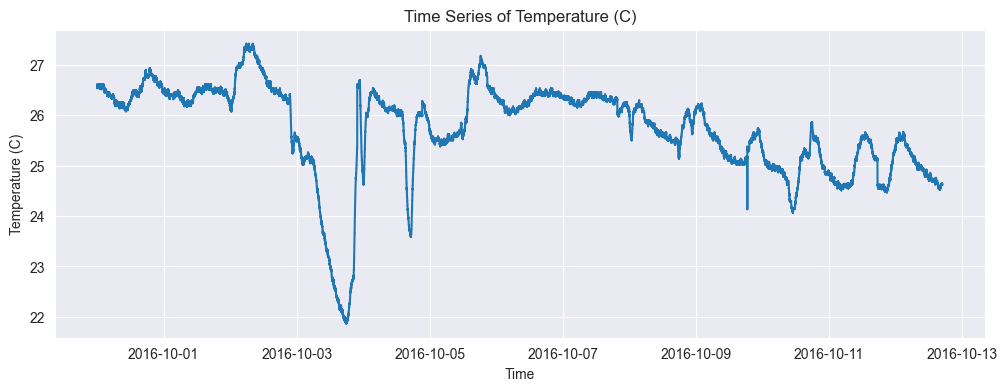

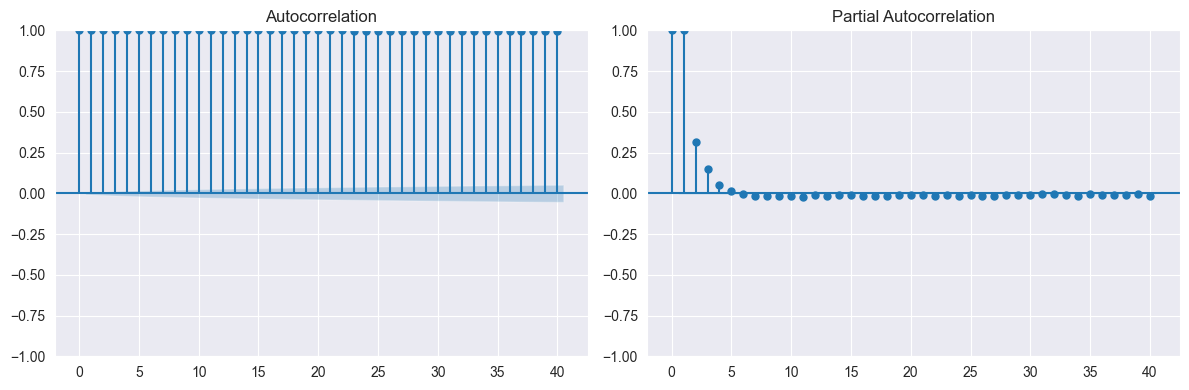

<Figure size 1200x800 with 0 Axes>

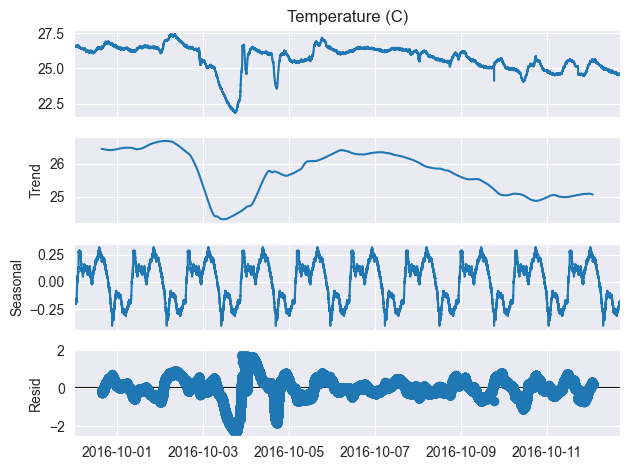

In [15]:
# Analyze variables for TSF suitability
variables_to_analyze = [
    # 'CO (ppm)', 
    # 'Humidity (%r.h.)', 
    'Temperature (C)', 
    # 'R1 (MOhm)',
]
for var in variables_to_analyze:
    analyze_variable_for_tsf(data, var)


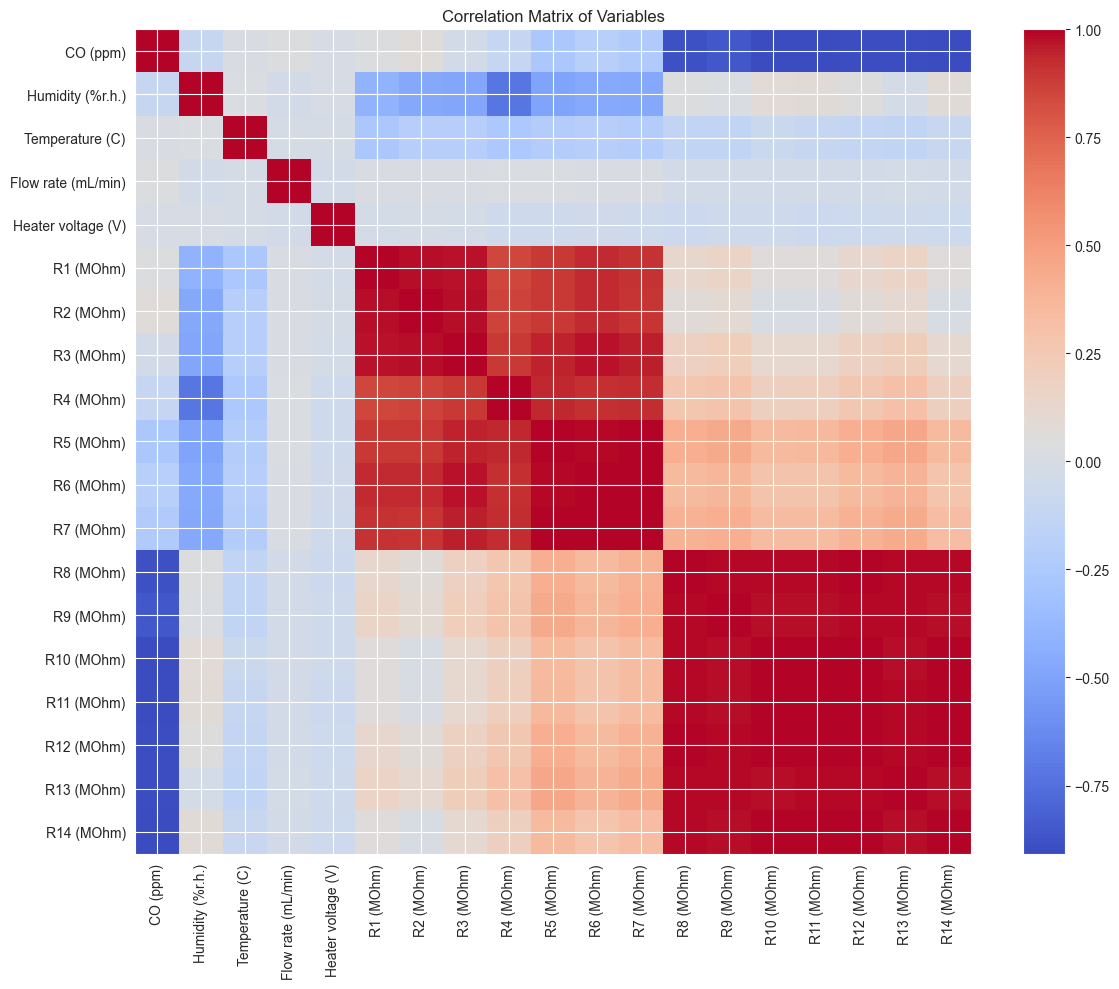

In [7]:
# Correlation analysis
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.show()